In [67]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.set_figure_params(dpi=80, facecolor='white')

Quick look at available data:

In [68]:
adata = sc.read_h5ad("../../data/schiller/schiller.h5ad")
adata

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 29271 × 23400
    obs: 'nGene', 'nUMI', 'orig.ident', 'identifier', 'res.2', 'grouping', 'cell.type', 'metacelltype', 'spline_cluster', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'size_factors', 'louvain_r1', 'louvain_fibro', 'louvain_krt', 'louvain_final'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_fibro_colors', 'louvain_final_colors', 'louvain_krt_colors', 'louvain_r1_colors', 'metacelltype_colors', 'neighbors', 'pca', 'rank_genes_r1'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [69]:
adata.obs["identifier"]

index
0        muc4169_PBS_d14
1        muc4169_PBS_d14
2        muc4169_PBS_d14
3        muc4169_PBS_d14
4        muc4169_PBS_d14
              ...       
29292    muc4657_PBS_d21
29293    muc4657_PBS_d21
29294    muc4657_PBS_d21
29295    muc4657_PBS_d21
29296    muc4657_PBS_d21
Name: identifier, Length: 29271, dtype: category
Categories (28, object): ['muc4169_PBS_d14', 'muc4170_PBS_d21', 'muc4171_Bleo_d7', 'muc4172_PBS_d10', ..., 'muc4653_Bleo_d3', 'muc4655_Bleo_d14', 'muc4656_Bleo_d14', 'muc4657_PBS_d21']

In [70]:
#define a function from best practices

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

Starting QC

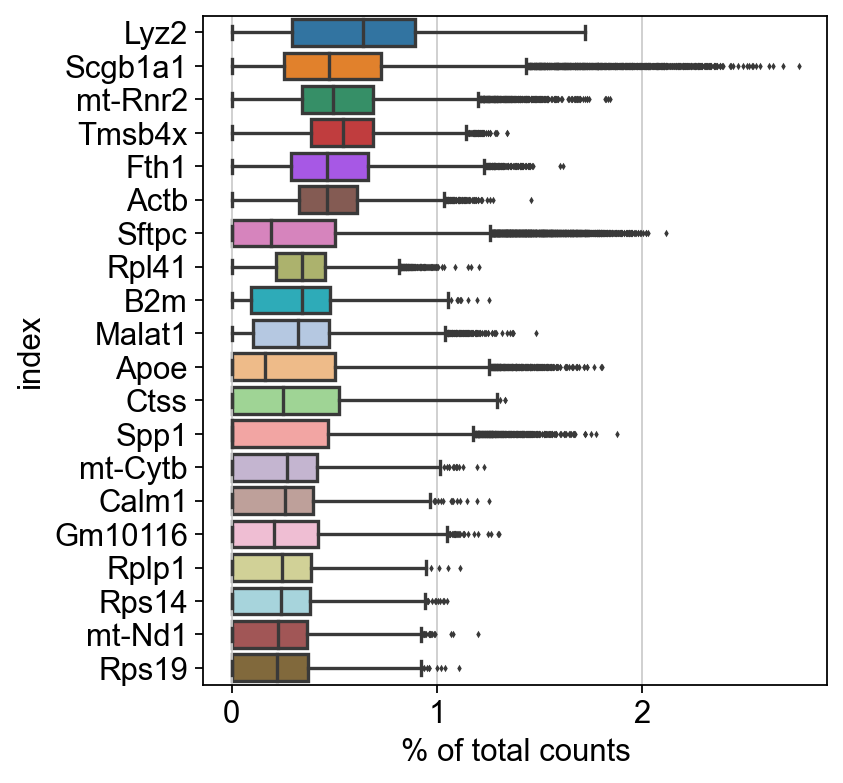

In [71]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Defining and calculating metrics to filter by

In [72]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(p)]"))

In [73]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 29271 × 23400
    obs: 'nGene', 'nUMI', 'orig.ident', 'identifier', 'res.2', 'grouping', 'cell.type', 'metacelltype', 'spline_cluster', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'size_factors', 'louvain_r1', 'louvain_fibro', 'louvain_krt', 'louvain_final', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'louvain', 'louvain_fibro_colors', 'louvain_final_colors', 'louvain_krt_colors', 'louvain_r1_colors', 'metacelltype_colors', 'neighbors', 'pca', 'rank_genes_r1'
    obsm: 

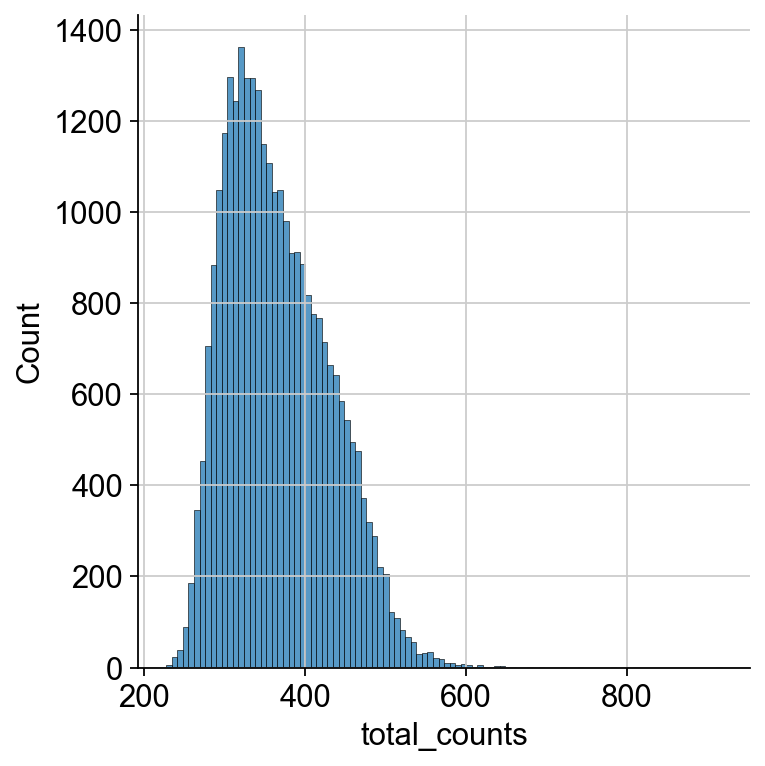

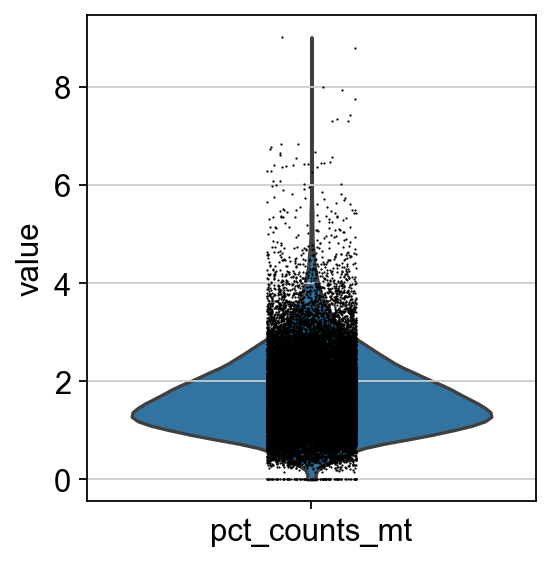

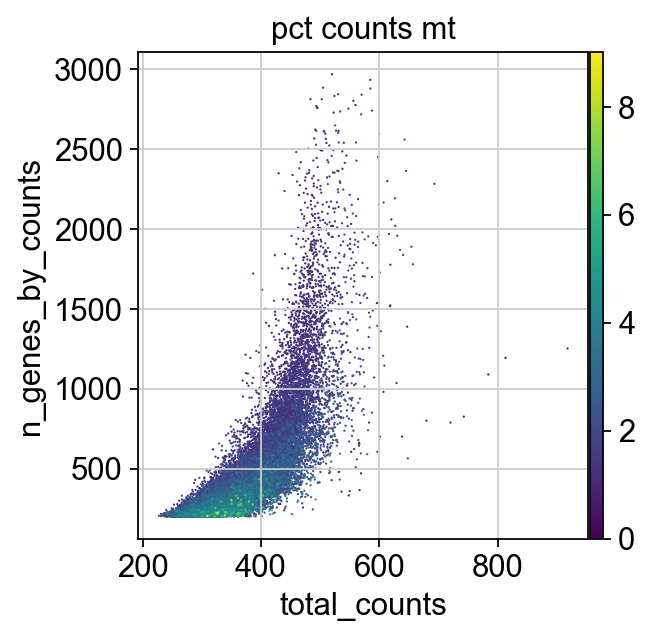

In [74]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [75]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    29058
True       213
Name: count, dtype: int64

In [76]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 6
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    27339
True      1932
Name: count, dtype: int64

Actually filtering the low quality cells out

In [77]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 29271
Number of cells after filtering of low quality cells: 27126


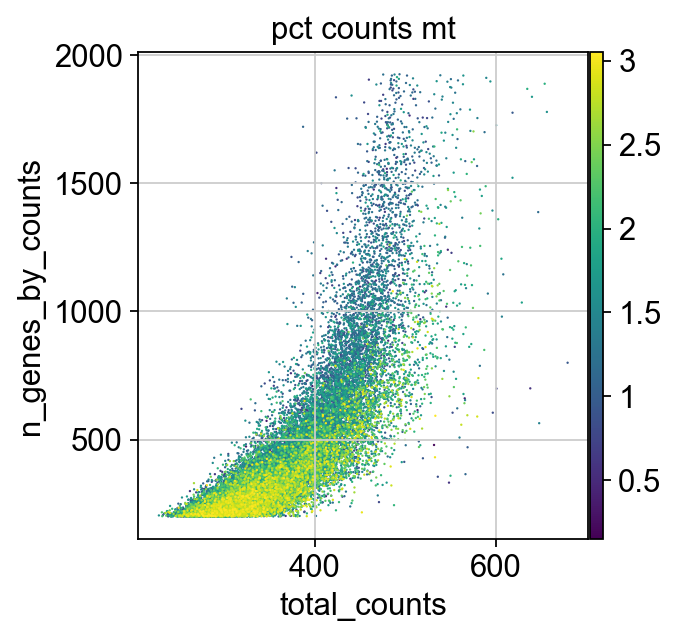

In [78]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [79]:
#sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

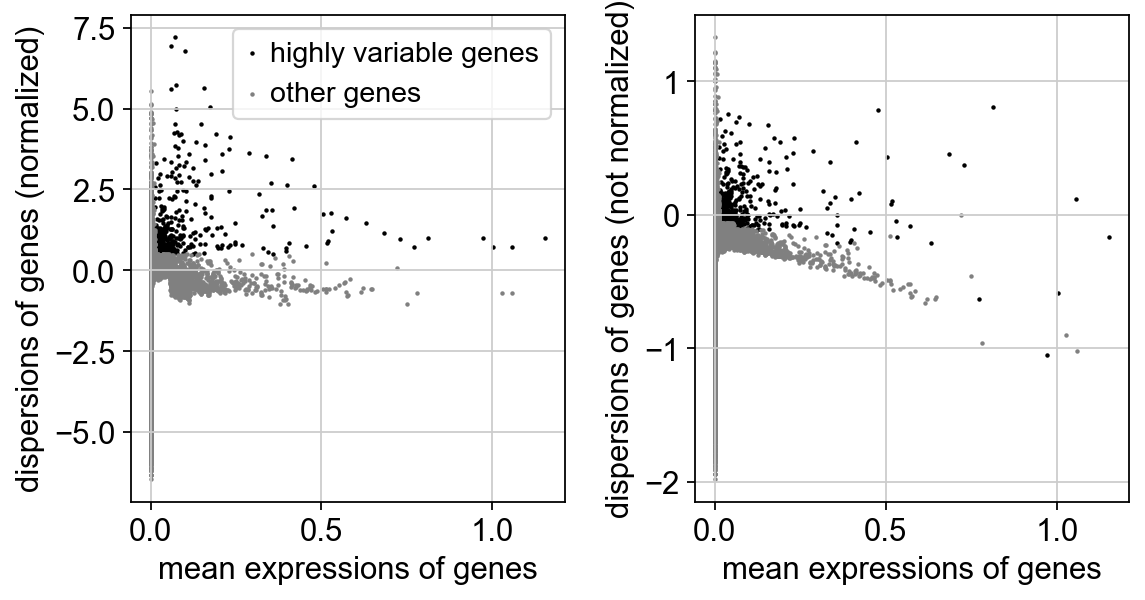

In [80]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

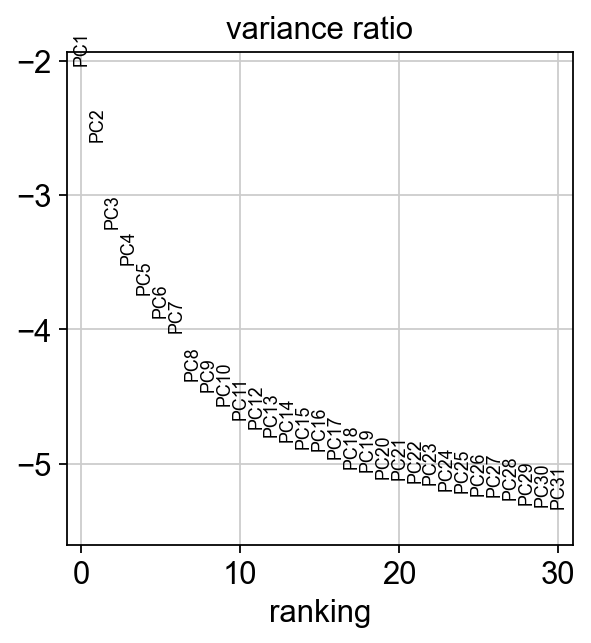

In [81]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [82]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=31) #taking all the PCs

Trying different leiden resolutions

In [83]:
sc.tl.leiden(adata)
sc.tl.leiden(adata, resolution=0.8, key_added="leiden0.8")
sc.tl.leiden(adata, resolution=1.2, key_added="leiden1.2")

In [84]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [85]:
sc.tl.umap(adata)

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


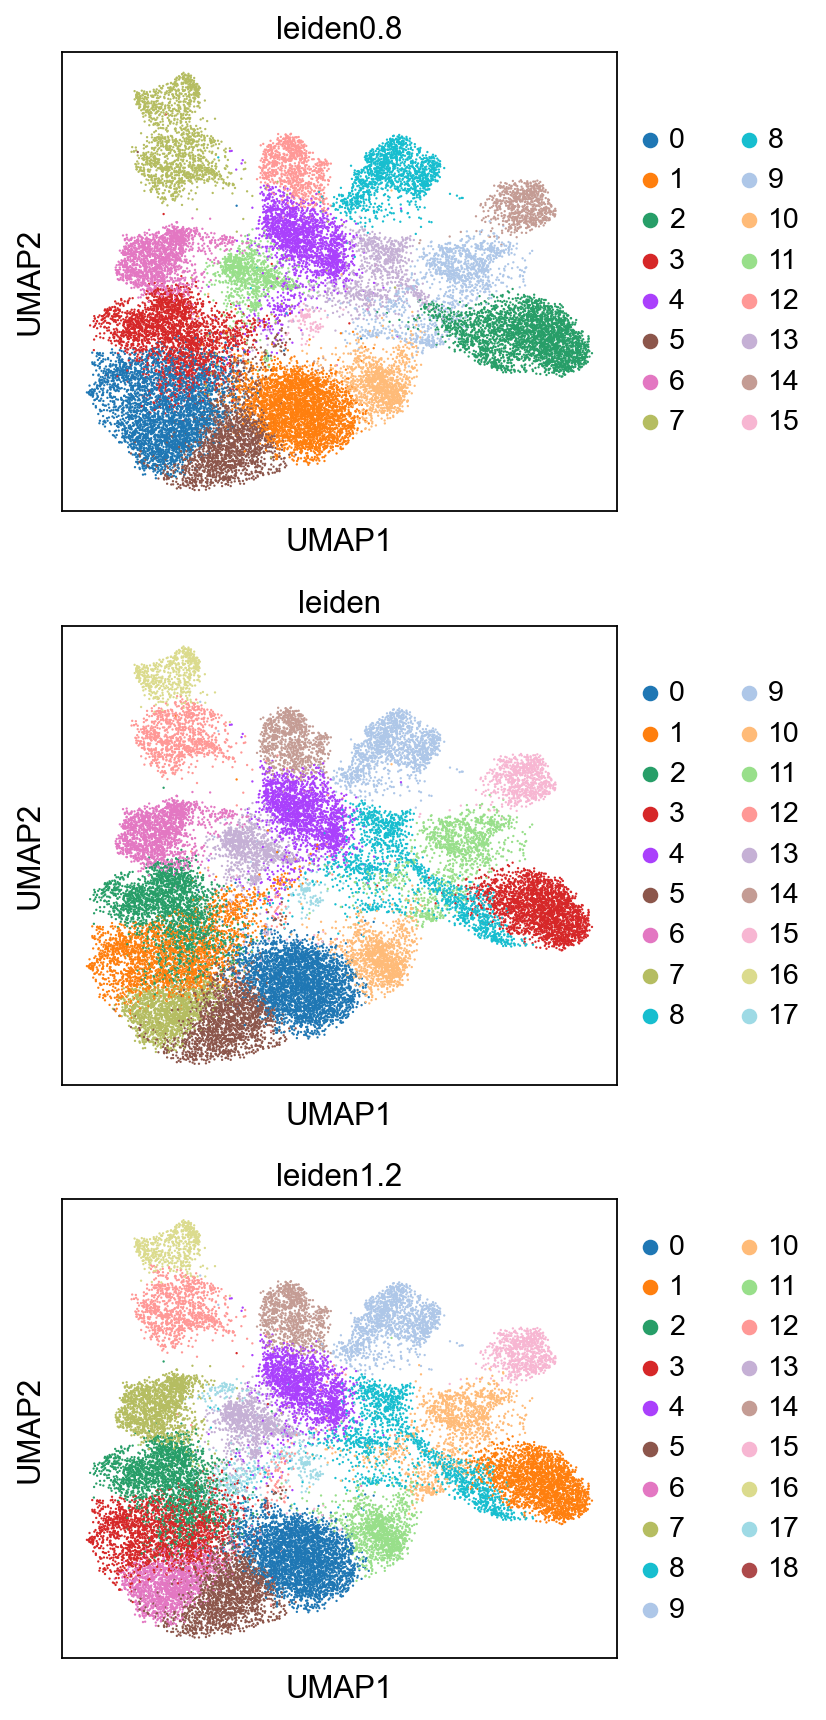

In [86]:
sc.pl.umap(adata, color=['leiden0.8', 'leiden', 'leiden1.2'],ncols=1)

the 0.8 resolution looks to work best, comparing it to the existing cell type labels:

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


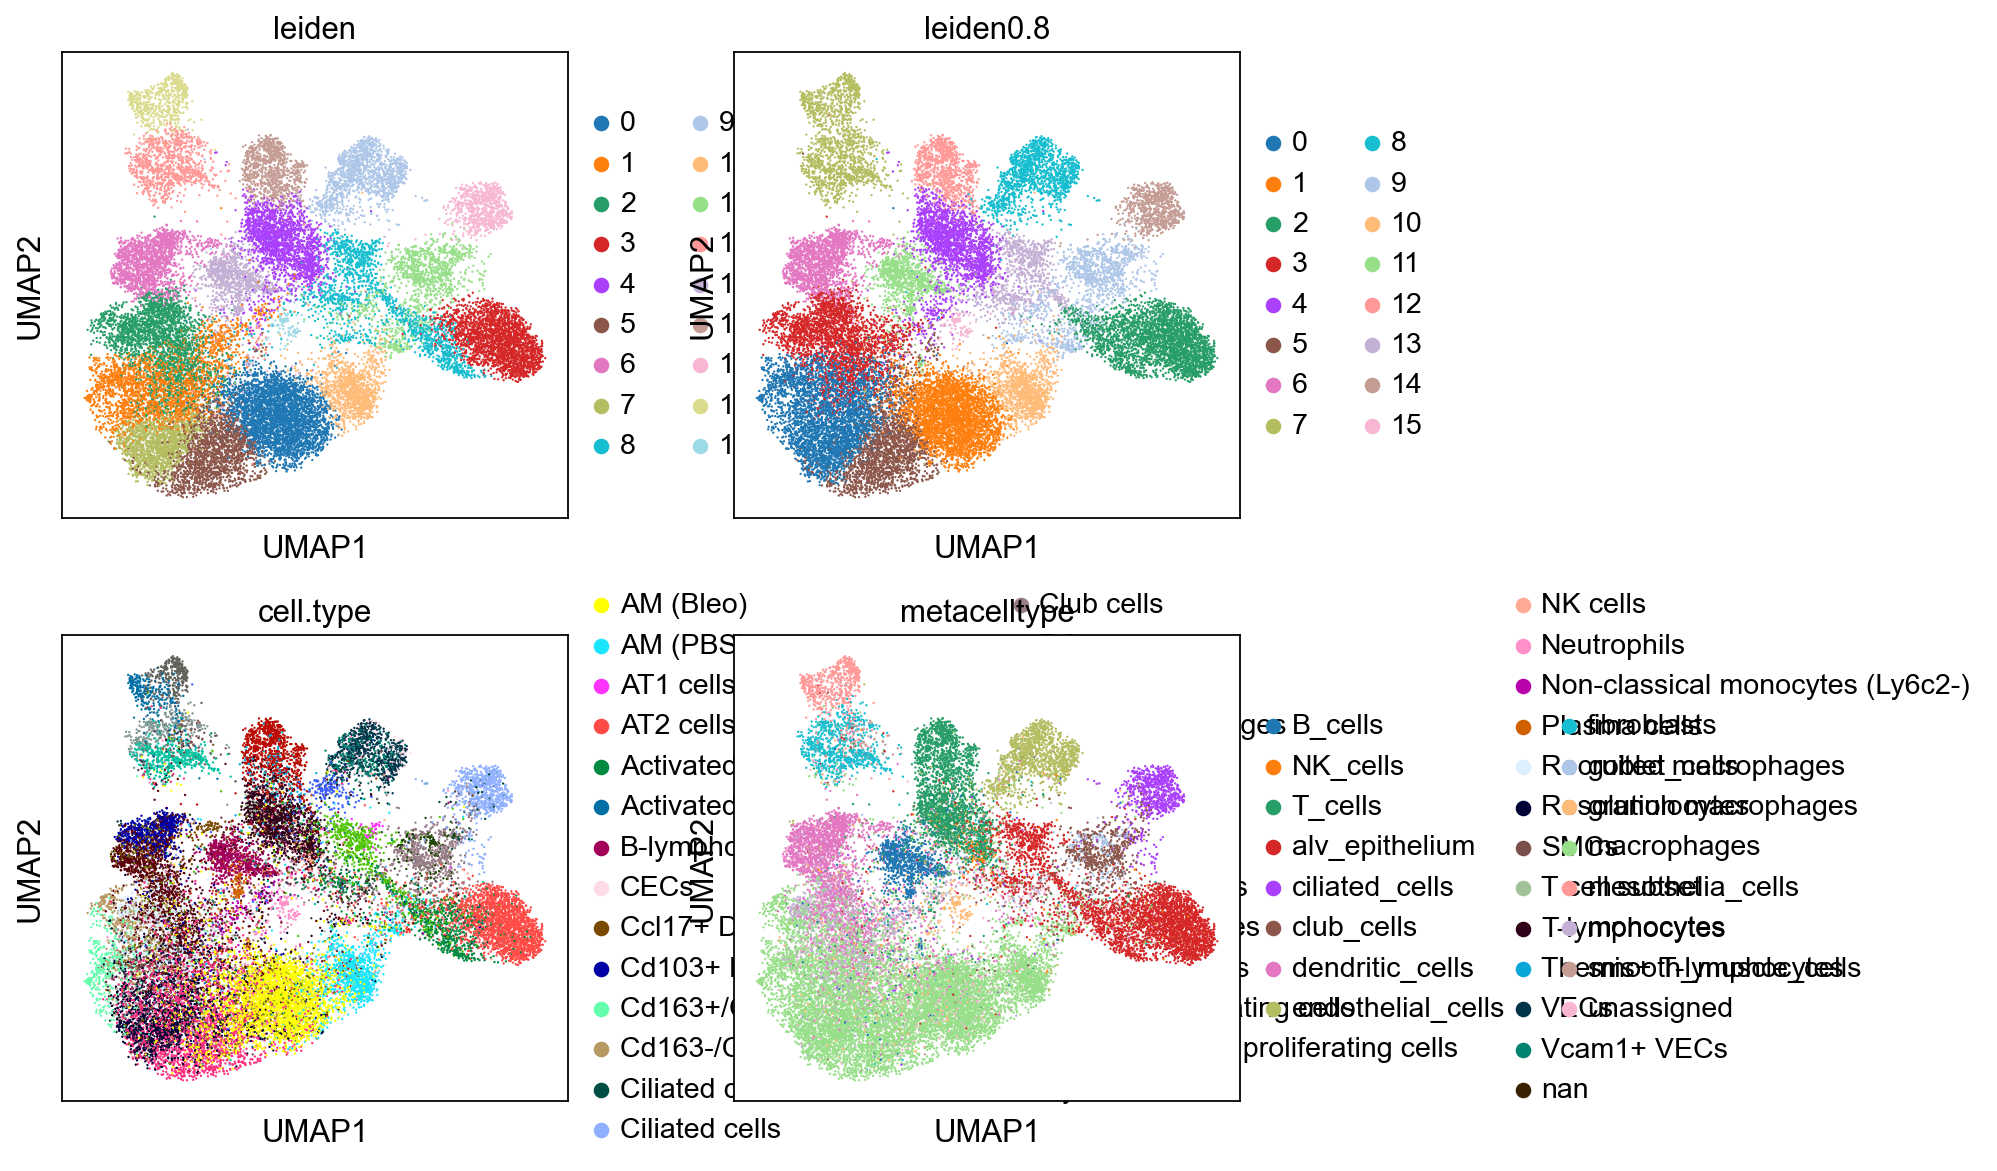

In [87]:
sc.pl.umap(adata, color=['leiden', 'leiden0.8', 'cell.type', 'metacelltype'], ncols=2)

check for batch effects:

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


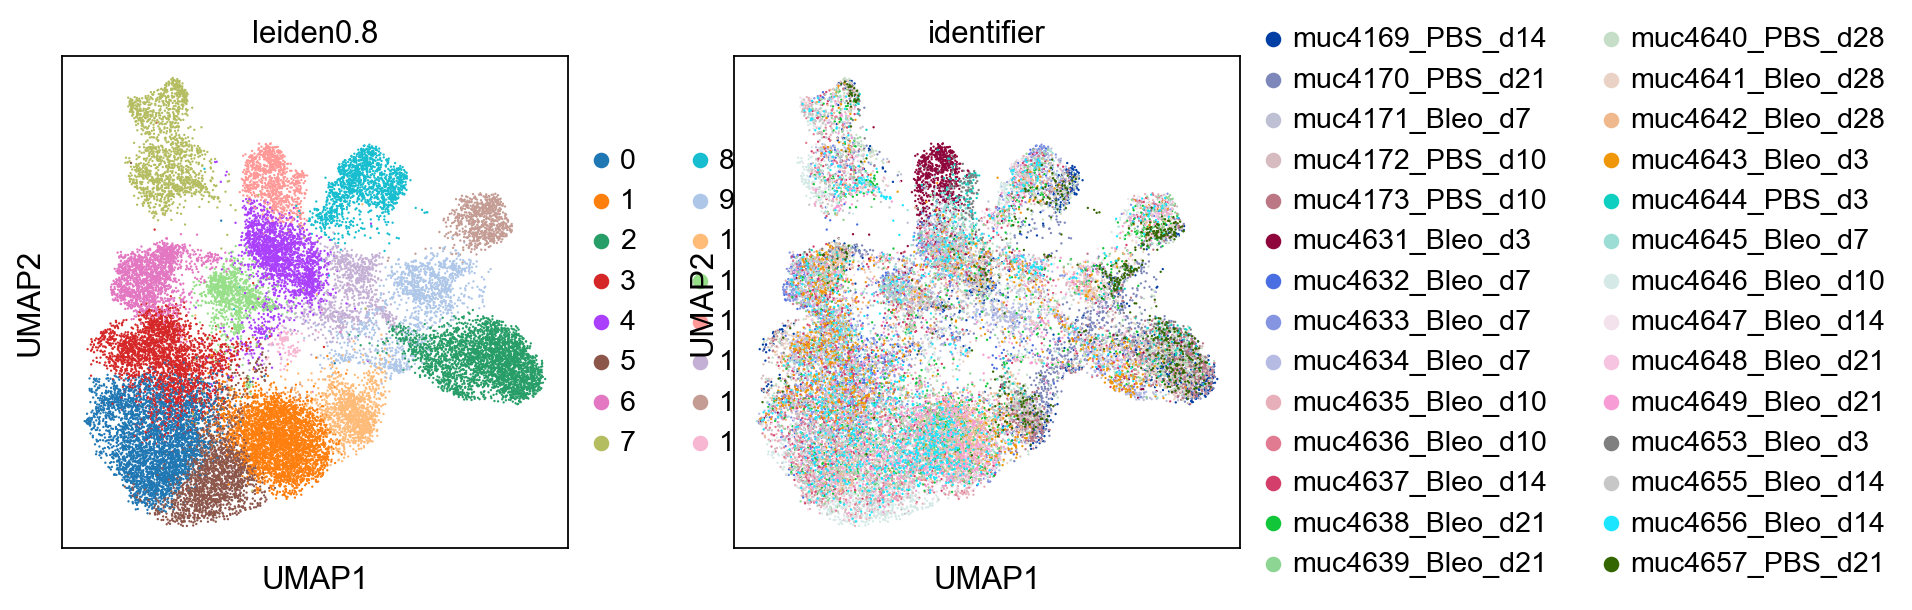

In [88]:
sc.pl.umap(adata, color=['leiden0.8', "identifier"])

The samples look to be well integrated, with only muc4631_Bleo_d3 somewhat standing out

/home/d/danilina/mambaforge/envs/scanpy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


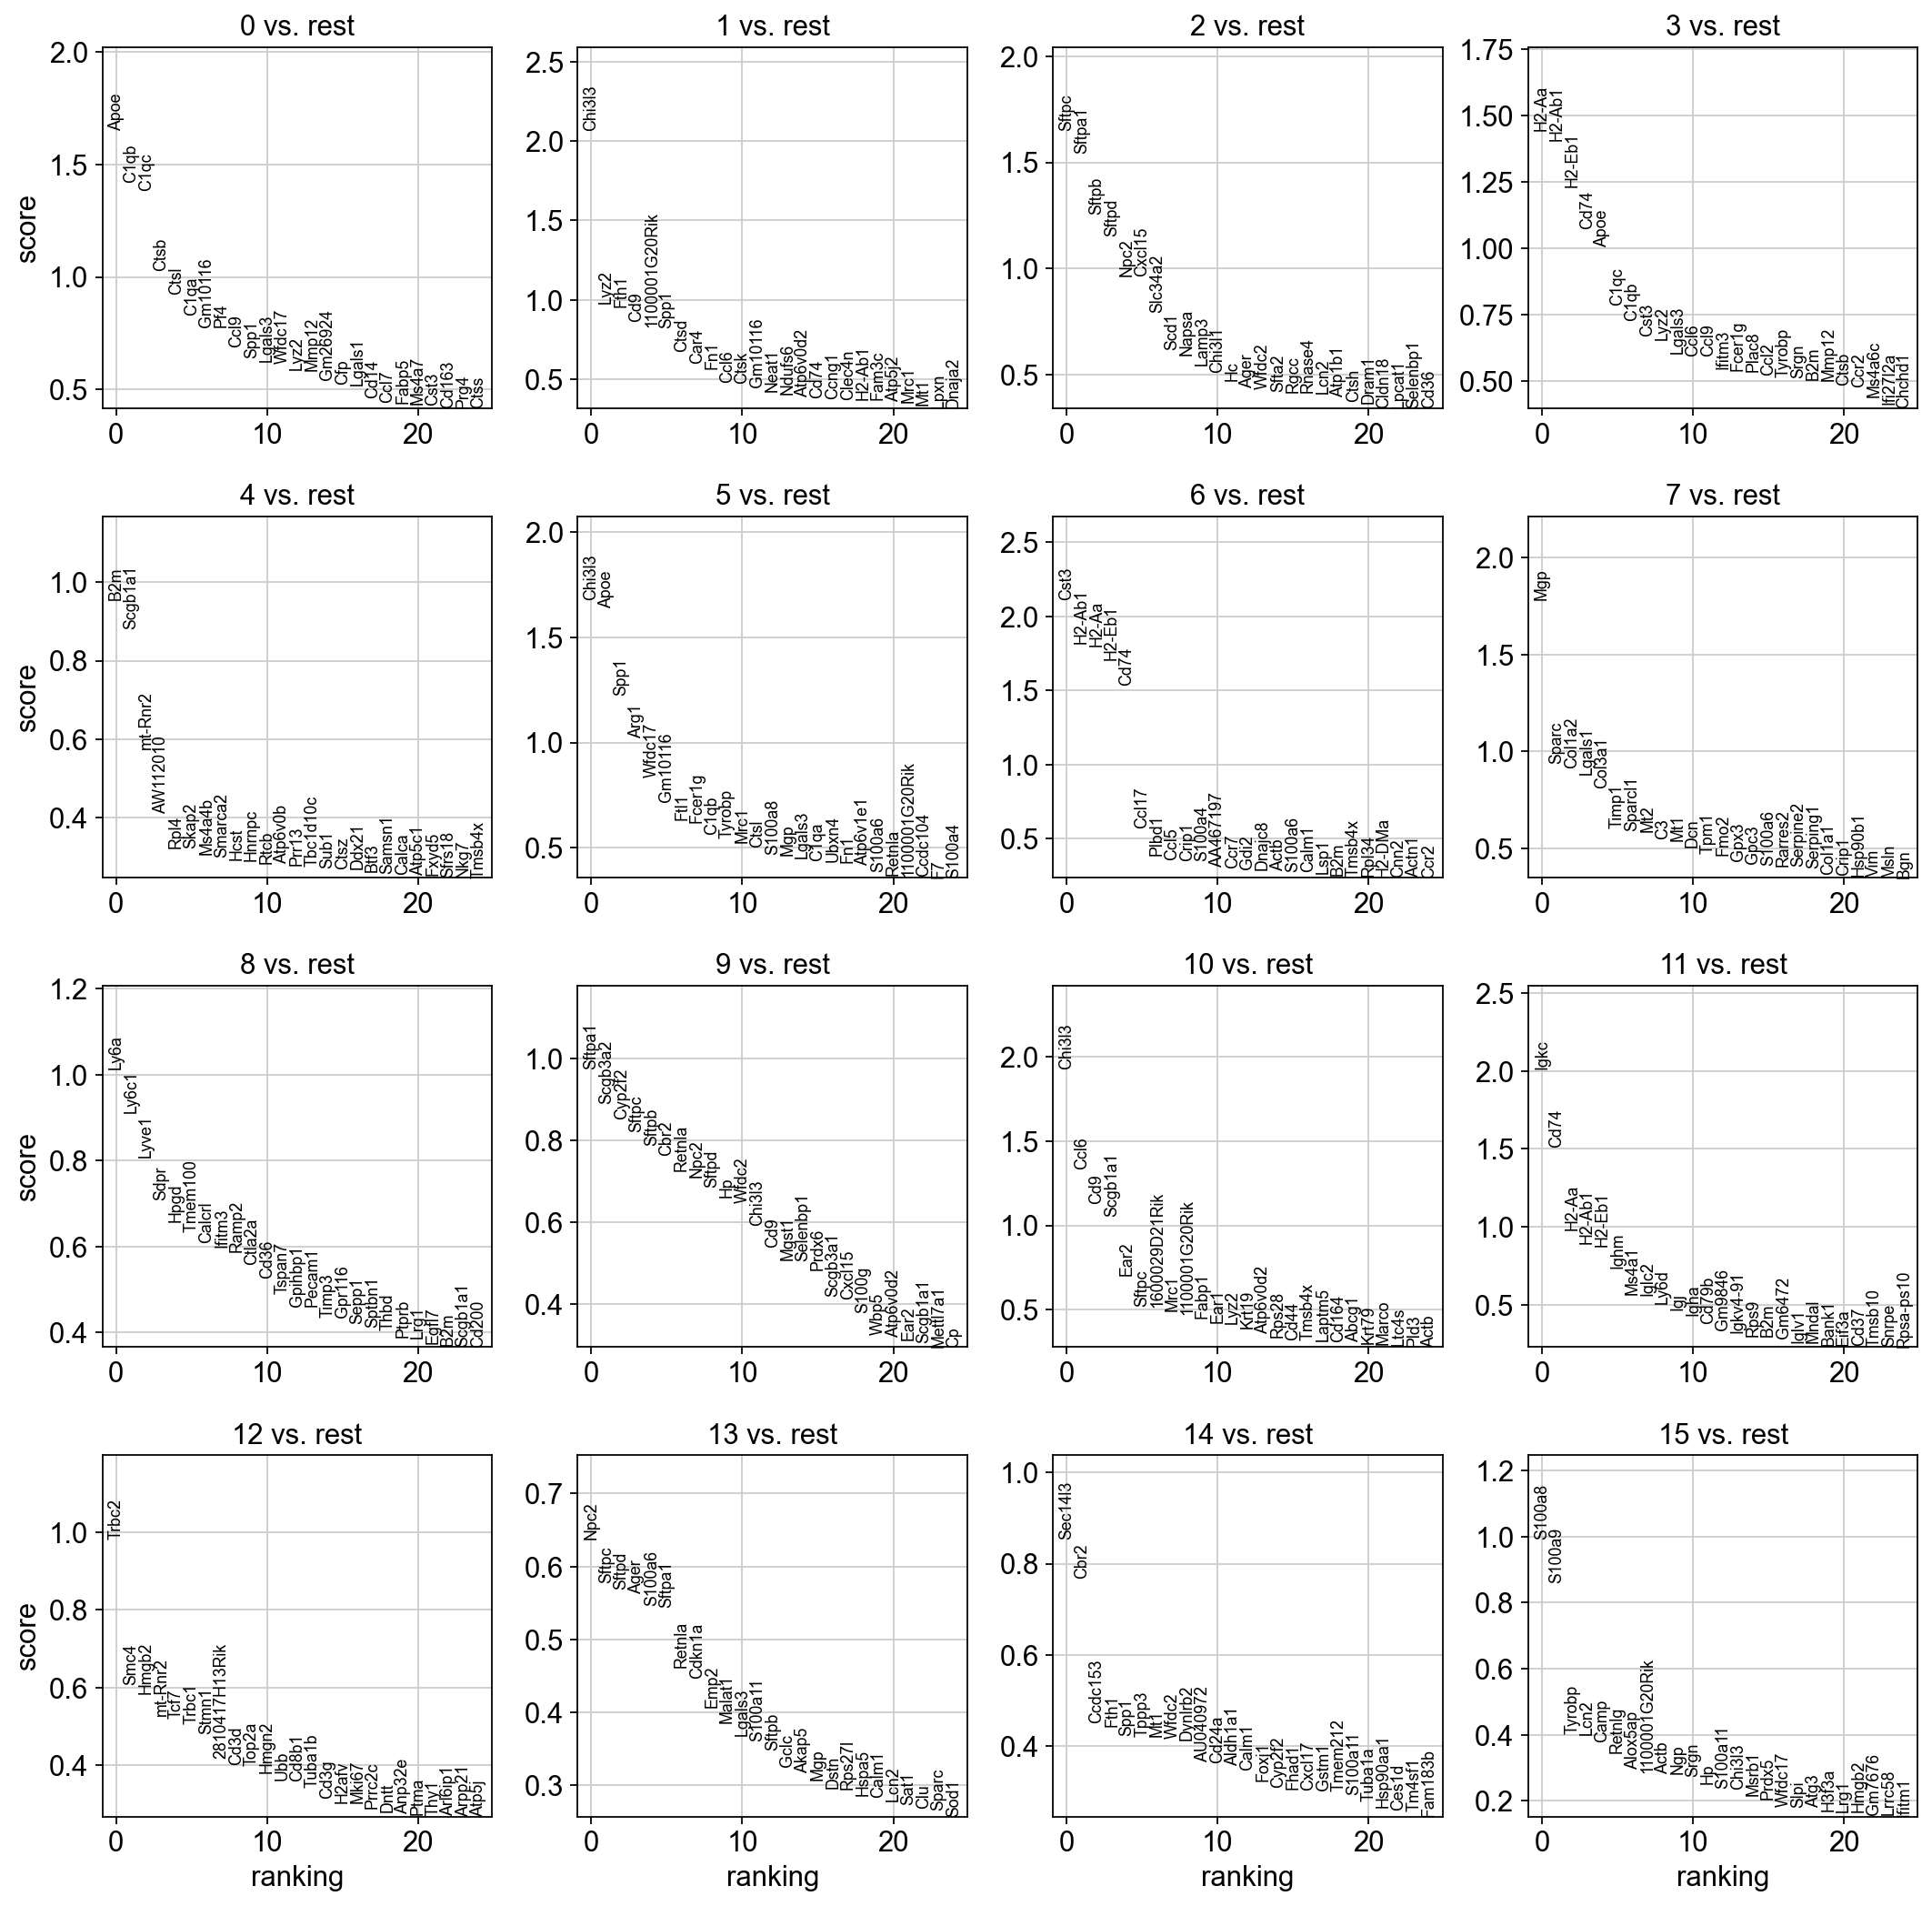

In [89]:
sc.tl.rank_genes_groups(adata, 'leiden0.8', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)